In [1]:
# this chemkin file is from the cti generated by rmg

# load a bunch of stuff
from __future__ import division
# load
import cantera as ct
import numpy as np
import scipy
import pylab
import matplotlib
import matplotlib.pyplot  as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import NullFormatter, MaxNLocator, LogLocator
import csv
from pydas.dassl import DASSL
import os
import rmgpy
import rmg
import re
import operator
import pandas as pd
%matplotlib inline

gas = ct.Solution('./chem.cti','gas')
surf = ct.Interface('./chem.cti','surface1', [gas])
print "This mechanism contains %d gas reactions and %d surface reactions"%(gas.n_reactions, surf.n_reactions)
i_n2 = gas.species_index('N2')
i_ch4 = gas.species_index('CH4(2)')
i_o2 = gas.species_index('O2(3)')
i_co2 = gas.species_index('CO2(4)')
i_h2o = gas.species_index('H2O(5)')
i_h2 = gas.species_index('H2(6)')
i_co = gas.species_index('CO(7)')

/home/mazeau.e/Code/RMG-Py/rmgpy/tools/plot.py:34: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/mazeau.e/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/mazeau.e/anaconda2/envs/rmg_env/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/mazeau.e/anaconda2/envs/rmg_env/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mazeau.e/anaconda2/envs/rmg_env/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mazeau.e/anaconda2/envs/rmg_env/lib/pyt

This mechanism contains 22 gas reactions and 81 surface reactions


The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.
  1.000000e-04    0.099635    0.099390    0.800155
  2.238721e-04    0.099260    0.098664    0.800338
  5.011872e-04    0.098429    0.097049    0.800750
  1.122018e-03    0.096618    0.093479    0.801682
  2.511886e-03    0.092782    0.085774    0.803741
  5.623413e-03    0.085188    0.070289    0.807854
  1.258925e-02    0.072927    0.045181    0.813993
  2.818383e-02    0.061139    0.021094    0.818730
  6.309573e-02    0.055629    0.009896    0.820188
  1.412538e-01    0.053855    0.006312    0.820468
  3.162278e-01    0.053256    0.005107    0.820532
  7.079458e-01    0.053027    0.004647    0.820550
  1.584893e+00    0.052932    0.004455    0.820557
  3.548134e+00    0.052889    0.004369    0.820560
  7.943282e+00    0.052867    0.004327    0.820561
  1.778279e+01    0.052854    0.004301    0.820561
  3.981072e+01    0.052842    0.004276    0.820

Text(0.5,0,u'Time(s)')

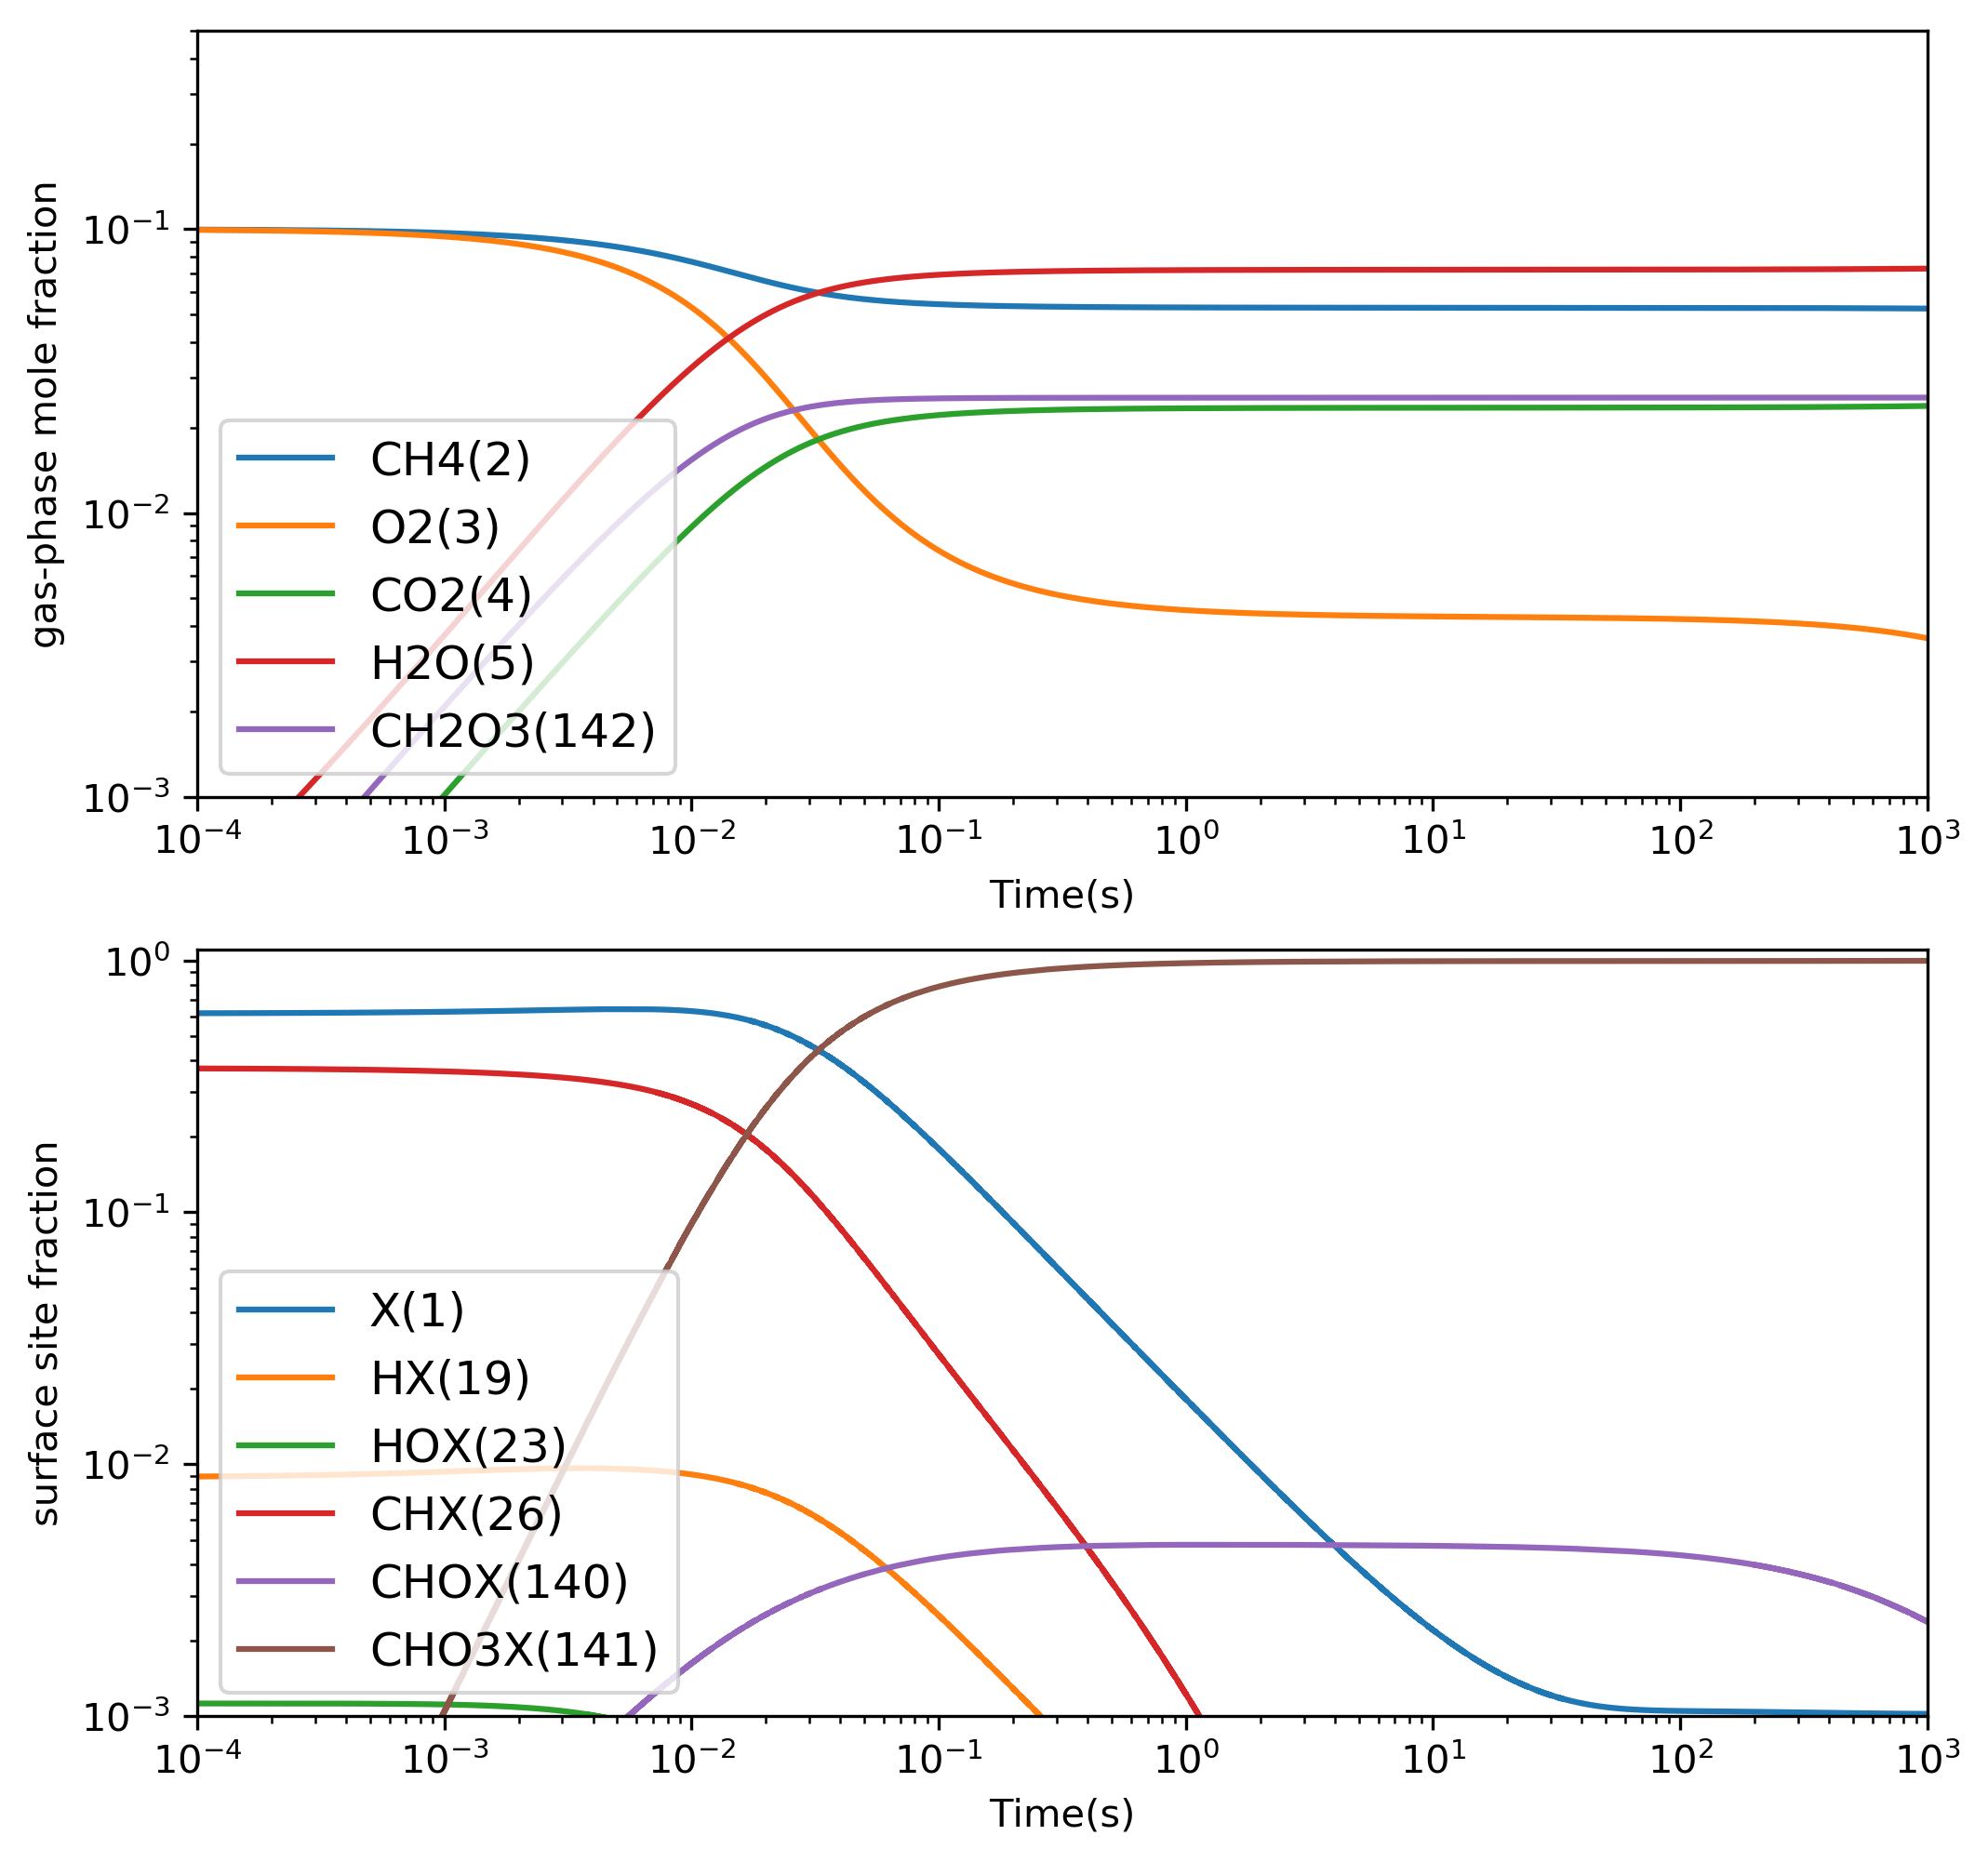

In [2]:
#######################################################################
# Input Parameters
#######################################################################

volume = 1.0
cat_area_per_vol = 1.0E2 #I made this up!

cat_area = cat_area_per_vol * volume

#initial conditions
T0 = 800.
P0 = 1.0 #bar
#initial composition (gas mol fraction)
CH4_0 = 0.1
O2_0 = 0.1
N2_0 = 0.8
CO2_0 = 0.

gas.TPX = T0, P0 * ct.one_atm, {'CH4(2)':CH4_0, 'O2(3)':O2_0, 'N2':N2_0, 'CO2(4)':CO2_0}
          #Temp, Pressure, mole fraction
surf.TP = T0, P0 * ct.one_atm
surf.coverages = {'X(1)':1.0}
#surf.coverages = {'PT(S)':0.9, 'O(S)':0.1}

r = ct.IdealGasConstPressureReactor(gas, energy='off')
r.volume = volume
rsurf = ct.ReactorSurface(surf, r, A=cat_area) # A=cat_area

sim = ct.ReactorNet([r])
sim.max_err_test_fails = 12

# set relative and absolute tolerances on the simulation
sim.rtol = 1.0e-12
sim.atol = 1.0e-18

#rxn_time = np.linspace(1E-12, 5, 10001) #
rxn_time = np.logspace(-4, 3, 10001) #from 0s to 1000s, log spacing

gas_mole_fracs = np.zeros([gas.n_species, len(rxn_time)])
surf_site_fracs = np.zeros([surf.n_species, len(rxn_time)])
temperature = np.zeros(len(rxn_time))    
pressure = np.zeros(len(rxn_time))   

for i in range(len(rxn_time)):
    time = rxn_time[i] #define time in the reactor
    sim.advance(time) #Advance the simulation to next set time
    temperature[i] = gas.T
    pressure[i] = gas.P/ct.one_atm
    gas_mole_fracs[:,i] = gas.X #
    surf_site_fracs[:,i] = surf.coverages #
    if not i % 500:
        print('  {0:10e}  {1:10f}  {2:10f}  {3:10f}'.format(time, *gas['CH4(2)','O2(3)','N2'].X))



#sim.advance_to_steady_state()
#print('  {0:10e}  {1:10f}  {2:10f}  {3:10f}'.format(sim.time, *gas['CH4','H2','CO'].X))    
    
# CH4_ref = gas_mole_fracs[i_ch4,:]

# setting new sensitivity to be based on time to consume 95% of the o2
zipped = zip(gas_mole_fracs[i_o2,:],rxn_time)
zipped = [list(z) for z in zipped]
for z in zipped:
    if z[0] <= O2_0 * .05:
        O2_ref_time = z[1]
        break

#Plot out simulations results
fig = pylab.figure(dpi=300,figsize=(8,8))
gs = gridspec.GridSpec(2, 1)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

y_min = 1E-3

for i in range(gas.n_species):
    if i != i_n2:
        if np.max(gas_mole_fracs[i,:]) > y_min:
            ax0.loglog(rxn_time, gas_mole_fracs[i,:], label=gas.species_name(i) )

for i in range(surf.n_species):
    if np.max(surf_site_fracs[i,:]) > y_min:
        ax1.loglog(rxn_time, surf_site_fracs[i,:], label=surf.species_name(i) )
            
ax0.legend(loc='lower left', fontsize = 12)
ax1.legend(loc='lower left', fontsize = 12)

ax0.set_ylabel("gas-phase mole fraction")
ax0.set_ylim(y_min,0.5)
ax0.set_xlim(1.0E-4,max(rxn_time))
ax1.set_xlim(1.0E-4,max(rxn_time))
ax0.set_xlabel("Time(s)")
ax1.set_ylabel("surface site fraction")
#ax0.xaxis.set_major_locator(MaxNLocator(6))
#ax0.yaxis.set_major_locator(LogLocator(base=10.0, numticks=3))
#ax0.tick_params(axis='both', which='major', labelsize=10)
ax1.set_ylim(y_min, 1.1 )
ax1.set_xlabel("Time(s)")


In [3]:
# Set the value of the perturbation
dk = 1.0e-2
# create the array to hold the sensitivty at each time step
Sensitivity = np.zeros([surf.n_reactions,len(rxn_time)])

rxns = []
sens = []

#cycle through each reaction
for m in range(surf.n_reactions):
    surf.set_multiplier(1.0) # reset all multipliers  
    surf.set_multiplier(1+dk, m) # perturb reaction m
    
    gas.TPX = T0, P0 * ct.one_atm, {'CH4(2)':CH4_0, 'O2(3)':O2_0, 'N2':N2_0}
              #Temp, Pressure, mole fraction
    surf.TP = T0, P0 * ct.one_atm
    surf.coverages = {'X(1)':1.0}
    
    r = ct.IdealGasConstPressureReactor(gas, energy='off')
    r.volume = volume
    rsurf = ct.ReactorSurface(surf, r, A=cat_area) # A=cat_area


    sim = ct.ReactorNet([r])
    sim.max_err_test_fails = 12


    # set relative and absolute tolerances on the simulation
    sim.rtol = 1.0e-12
    sim.atol = 1.0e-18
    gas_mole_fracs = np.zeros([gas.n_species, len(rxn_time)])
    temperature = np.zeros(len(rxn_time))    
    pressure = np.zeros(len(rxn_time))   

    for i in range(len(rxn_time)):
        time = rxn_time[i] #define time in the reactor
        sim.advance(time) #Advance the simulation to next set time
        temperature[i] = gas.T
        pressure[i] = gas.P/ct.one_atm
        gas_mole_fracs[:,i] = gas.X #[mol.frac,nth reactor]
    # here is the new output
#     CH4_new = gas_mole_fracs[i_ch4,:]

    O2_new = gas_mole_fracs[i_o2,:]
    zipped = zip(gas_mole_fracs[i_o2,:],rxn_time)
    zipped = [list(z) for z in zipped]
    for z in zipped:
        if z[0] <= O2_0 * .05:
            O2_new_time = z[1]
            break

#     Sens = (CH4_new-CH4_ref)/(CH4_ref*dk)
    Sens = (O2_ref_time - O2_new_time)/(O2_ref_time*dk) # positive if it speeds up the reaction
#     max_sensitivity = max(max(Sens),-min(Sens))
#    if (1==0):
#        if (max_sensitivity>0.01):
#            print "%d %s %.2F"%( m, surf.reaction_equations()[m],  max_sensitivity)
#    else:
#     print "%d %s %.2F"%( m, surf.reaction_equations()[m],  max_sensitivity)
    print "%d %s %.2F"%( m, surf.reaction_equations()[m],  Sens)
#     Sensitivity[m,:] = Sens
    rxns.append(surf.reaction_equations()[m])
    sens.append(Sens)
surf.set_multiplier(1.0)

 

0 CH4(2) + X(1) <=> CH4X(33) 0.00
1 O2(3) + 2 X(1) <=> 2 OX(20) 9.22
2 C2H6(8) + 2 X(1) <=> 2 CH3X(22) 0.00
3 CH3(10) + X(1) <=> CH3X(22) 0.00
4 CH3X(22) + HOX(23) <=> CH4(2) + OX(20) + X(1) 2.86
5 2 HOX(23) <=> H2O(5) + OX(20) + X(1) 0.00
6 CH3OH(14) + 2 X(1) <=> CH3X(22) + HOX(23) 0.00
7 OH(17) + X(1) <=> HOX(23) 0.00
8 H2(6) + 2 X(1) <=> 2 HX(19) 0.00
9 CH3X(22) + HX(19) <=> CH4(2) + 2 X(1) 0.16
10 HOX(23) + HX(19) <=> H2O(5) + 2 X(1) 3.02
11 H(12) + X(1) <=> HX(19) 0.00
12 HOX(23) + X(1) <=> HX(19) + OX(20) 0.00
13 CH2X(134) + HX(19) <=> CH3X(22) + X(1) 0.16
14 CH2X(134) + HOX(23) <=> CH3X(22) + OX(20) 0.00
15 CHX(26) + HX(19) <=> CH2X(134) + X(1) 0.00
16 CHX(26) + HOX(23) <=> CH2X(134) + OX(20) 0.00
17 2 CH2X(134) <=> CH3X(22) + CHX(26) 0.00
18 H2O(5) + X(1) <=> H2OX(35) 0.00
19 H2(6) + X(1) <=> H2X(36) 0.00
20 CH3OH(14) + X(1) <=> CH3OHX(46) 0.00
21 CX(24) + HX(19) <=> CHX(26) + X(1) 0.00
22 CX(24) + HOX(23) <=> CHX(26) + OX(20) 0.00
23 CH3X(22) + CX(24) <=> CH2X(134) + CHX(26) 0

In [4]:
#Plot out simulations results
# fig = pylab.figure(dpi=300,figsize=(8,8))
# gs = gridspec.GridSpec(1, 1)
# ax0 = plt.subplot(gs[0])


# for m in range(surf.n_reactions):
#     y_max = 0.00001
#     if (1==1):
#         if max(Sensitivity[m,:])>y_max or min(Sensitivity[m,:])<-y_max:
#             lab = surf.reaction_equations()[m]
#             ax0.semilogx(rxn_time, Sensitivity[m,:], label=lab )
#     else:
#         if max(Normed_sensitivity[m,:])>y_max or min(Normed_sensitivity[m,:])<-y_max:
#             lab = surf.reaction_equations()[m]
#             ax0.semilogx(rxn_time, Normed_sensitivity[m,:], label=lab )
        
# ax0.legend(loc='best', fontsize = 12)   
# ax0.set_xlim(rxn_time[1], rxn_time[-1] )

# ax0.set_xlabel("Time(s)")
# ax0.set_ylabel("Sensitivity Coefficient")

In [5]:
# # now integrate with respect to time
# from numpy import trapz

# # for m in range(surf.n_reactions):
# #     ans = trapz(Sensitivity[m,:], rxn_time)#/max(rxn_time)
# #     if ans>1E-4:
# #         print "%d %s %.5f"%( m, surf.reaction_equations()[m], ans )

# n = []
# rxns = []
# for m in range(surf.n_reactions):
#     n.append(trapz(Sensitivity[m,:], rxn_time))#/max(rxn_time)
#     rxns.append(surf.reaction_equations()[m])

# ans = dict(zip(rxns,n))
# sorted_ans = sorted(ans.items(), key=operator.itemgetter(1), reverse=True)

# for x in sorted_ans:
#     print '%s %.4f'%(x)

In [6]:
species_dict = rmgpy.data.kinetics.KineticsLibrary().getSpecies('species_dictionary.txt')
keys = species_dict.keys()

# get the first listed smiles string for each molecule
smile = []
for s in species_dict:
    smile.append(species_dict[s].molecule[0])
    if len(species_dict[s].molecule) is not 1:
        print 'There are %d dupllicate smiles for %s:'%(len(species_dict[s].molecule),s)
        for a in range(len(species_dict[s].molecule)):
            print '%s'%(species_dict[s].molecule[a])
            
# translate the molecules from above into just smiles strings
smiles = []
for s in smile:
    smiles.append(s.toSMILES())
    
names = dict(zip(keys,smiles))

rxns_translated = []

# now replace each molecule with smiles
for x in rxns:
    for key, smile in names.iteritems():
        x = re.sub(re.escape(key), smile, x)
    rxns_translated.append(x)

answer = dict(zip(rxns_translated, sens))
sorted_answer = sorted(answer.items(), key=operator.itemgetter(1), reverse=True)
# for x in sorted_answer:
#     print '%s %.4f'%(x)

There are 2 dupllicate smiles for OX(20):
<Molecule "O=[Ni]">
<Molecule "[O-][Ni]">


In [7]:
# write to csv file
(pd.DataFrame.from_dict(data=sorted_answer, orient='columns')
.to_csv('dict.csv', header=False))
